# Demo of Gated Recurrent Unit

In [1]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/gru
import tensorflow as tf # version tensorflow==2.4.0
from tensorflow import keras
from tensorflow.keras import layers

# Set Random seed
import random
random.seed(2505)

# Cleaning the Data 

In [2]:
# Daily Data on Gold.
tick = 'GC=F'
gold = web.get_data_yahoo(tick,'12/27/2015',interval='d')

In [3]:
gold

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-28,1098.800049,1070.500000,1077.900024,1070.500000,361.0,1070.500000
2015-12-29,1079.699951,1077.500000,1079.099976,1077.500000,252.0,1077.500000
2015-12-30,1070.199951,1059.699951,1068.599976,1060.099976,71.0,1060.099976
2015-12-31,1062.000000,1058.500000,1061.900024,1060.300049,10.0,1060.300049
2016-01-04,1082.500000,1063.199951,1063.400024,1075.099976,143.0,1075.099976
...,...,...,...,...,...,...
2020-12-17,1896.199951,1874.199951,1874.199951,1887.199951,414.0,1887.199951
2020-12-18,1889.500000,1882.300049,1882.400024,1885.699951,276.0,1885.699951
2020-12-21,1908.000000,1869.099976,1884.800049,1879.199951,136.0,1879.199951


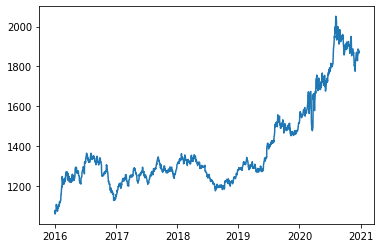

In [4]:
plt.plot(gold['Adj Close'])

In [5]:
returns = gold['Adj Close'].pct_change() # Used for univariate example.

column_names = gold.columns
x = gold.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [6]:
pct_c_gold = df

In [7]:
pct_c_gold.columns = column_names

In [8]:
pct_c_gold

,High,Low,Open,Close,Volume,Adj Close
0,0.036763,0.012226,0.016267,0.010490,0.000110,0.010490
1,0.017682,0.019358,0.017487,0.017551,0.000077,0.017551
2,0.008192,0.001223,0.006812,0.000000,0.000022,0.000000
3,0.000000,0.000000,0.000000,0.000202,0.000003,0.000202
4,0.020480,0.004789,0.001525,0.015130,0.000044,0.015130
...,...,...,...,...,...,...
1325,0.833367,0.831075,0.825844,0.834275,0.000127,0.834275
1326,0.826673,0.839328,0.834181,0.832762,0.000084,0.832762
1327,0.845155,0.825879,0.836621,0.826205,0.000042,0.826205
1328,0.819381,0.817626,0.833977,0.813496,0.000071,0.813496


# Univariate Forecasting (GRU)

In [9]:
returns

Date
2015-12-28         NaN
2015-12-29    0.006539
2015-12-30   -0.016149
2015-12-31    0.000189
2016-01-04    0.013958
                ...   
2020-12-17    0.016756
2020-12-18   -0.000795
2020-12-21   -0.003447
2020-12-22   -0.006705
2020-12-23    0.004339
Name: Adj Close, Length: 1330, dtype: float64

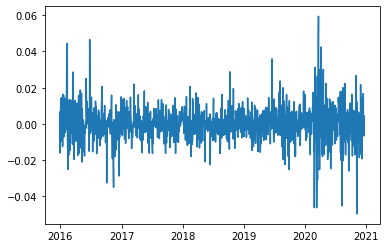

In [10]:
plt.plot(returns)

<AxesSubplot:>

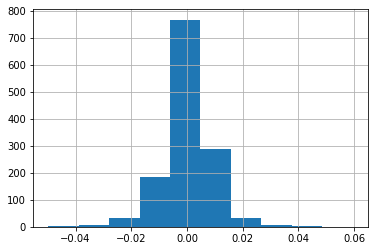

In [11]:
returns.hist()

In [12]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

1329
1329


In [13]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.51550642],
       [0.30786687],
       [0.4573878 ],
       [0.58340846],
       [0.48375329],
       [0.57023212],
       [0.58809324],
       [0.37386453],
       [0.44482225],
       [0.36468133]])]
Testing Data: Length is  1 :  [0.47167866393739416]


In [14]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (1319, 10, 1) Dimensions of Y (1319,)
Threshold is 1187


In [15]:
# Let's build the GRU
model = keras.Sequential()

# Add a GRU layer with 3 units.
model.add(layers.GRU(3,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3)                 54        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fitting the data
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
30/30 [==============================] - 3s 40ms/step - loss: 0.5140 - val_loss: 0.3420
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3021 - val_loss: 0.1943
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1712 - val_loss: 0.1045
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0979 - val_loss: 0.0543
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0592 - val_loss: 0.0306
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0389 - val_loss: 0.0213
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0341 - val_loss: 0.0180
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0168
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0304 - val_loss: 0.0161
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0255 - val_loss: 0.0157
Epoch 11

30/30 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0130
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0130
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0130
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0130
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0130
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0130
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0129
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0129
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0129
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0129
Epoch 93/100


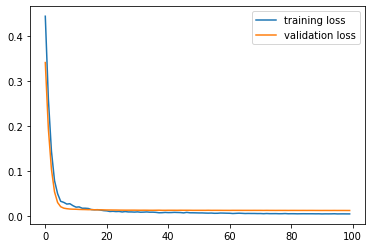

In [17]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

# Multi-Step Forecast

In [18]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
print(threshold)
true_Y = Y[threshold:]
pred_Y = []
print('Number of Forecasts to do: ',Y.shape[0] - round(Y.shape[0]*0.9))
latest_input = X[threshold-1:threshold]

for i in range(Y.shape[0] - round(Y.shape[0]*0.9) ):
    # Prediction
    p = model.predict(latest_input.reshape(1,X.shape[1],1))[0,0]
    
    # Update predictions
    pred_Y.append(p)
    latest_input = np.append(X[threshold][1:], p)

1187
Number of Forecasts to do:  132


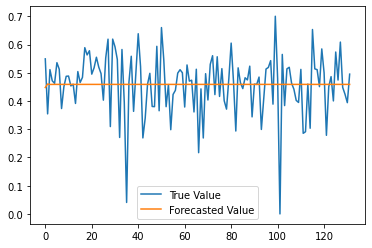

In [19]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# It's just predicting the mean.

In [21]:
pct_c_gold

,High,Low,Open,Close,Volume,Adj Close
0,0.036763,0.012226,0.016267,0.010490,0.000110,0.010490
1,0.017682,0.019358,0.017487,0.017551,0.000077,0.017551
2,0.008192,0.001223,0.006812,0.000000,0.000022,0.000000
3,0.000000,0.000000,0.000000,0.000202,0.000003,0.000202
4,0.020480,0.004789,0.001525,0.015130,0.000044,0.015130
...,...,...,...,...,...,...
1325,0.833367,0.831075,0.825844,0.834275,0.000127,0.834275
1326,0.826673,0.839328,0.834181,0.832762,0.000084,0.832762
1327,0.845155,0.825879,0.836621,0.826205,0.000042,0.826205
1328,0.819381,0.817626,0.833977,0.813496,0.000071,0.813496


# Multi-Variate Forecasting

# Using our Training and Testing sets, Let's create our inputs.

In [20]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_gold.shape[0] - samples):
    X.append(pct_c_gold.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_gold.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[3.67632855e-02, 1.22261844e-02, 1.62667755e-02, 1.04902402e-02,
        1.10363331e-04],
       [1.76822689e-02, 1.93581253e-02, 1.74867340e-02, 1.75509623e-02,
        7.70403306e-05],
       [8.19175941e-03, 1.22256869e-03, 6.81166260e-03, 0.00000000e+00,
        2.17058074e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01808793e-04,
        3.05715598e-06],
       [2.04795205e-02, 4.78853915e-03, 1.52501020e-03, 1.51301187e-02,
        4.37173305e-05],
       [1.94805195e-02, 1.71167079e-02, 1.39283769e-02, 1.84587940e-02,
        2.50686790e-05],
       [3.16682829e-02, 2.35353801e-02, 2.00284177e-02, 3.20759008e-02,
        1.58972111e-05],
       [4.73526717e-02, 3.37238671e-02, 3.01951524e-02, 4.80128852e-02,
        3.72973029e-05],
       [4.90509247e-02, 3.51502802e-02, 5.00202851e-02, 3.80271054e-02,
        2.99601286e-05],
       [4.58541702e-02, 3.87162506e-02, 4.45302235e-02, 3.67157792e-02,
        1.31457707e-05

In [22]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1320, 10, 5) Dimensions of Y (1320, 1)


In [23]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1188, 10, 5) (1188, 1) Testing Length: (132, 10, 5) (132, 1)


In [24]:
# Let's build the GRU
model = keras.Sequential()

# Add a GRU layer with 15 units.
model.add(layers.GRU(15,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 15)                990       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 1,006
Trainable params: 1,006
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Fitting the data
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
30/30 [==============================] - 2s 16ms/step - loss: 0.0044 - val_loss: 0.0072
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 9.8058e-04 - val_loss: 0.0012
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 8.7460e-04 - val_loss: 0.0018
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 8.3588e-04 - val_loss: 0.0

Epoch 78/100
30/30 [==============================] - 0s 5ms/step - loss: 2.8153e-04 - val_loss: 5.9273e-04
Epoch 79/100
30/30 [==============================] - 0s 5ms/step - loss: 2.6946e-04 - val_loss: 5.7635e-04
Epoch 80/100
30/30 [==============================] - 0s 4ms/step - loss: 2.9508e-04 - val_loss: 6.4550e-04
Epoch 81/100
30/30 [==============================] - 0s 5ms/step - loss: 2.5005e-04 - val_loss: 5.6941e-04
Epoch 82/100
30/30 [==============================] - 0s 4ms/step - loss: 3.1136e-04 - val_loss: 6.1424e-04
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 2.4987e-04 - val_loss: 5.5528e-04
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 2.5919e-04 - val_loss: 5.5116e-04
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 2.7901e-04 - val_loss: 5.4030e-04
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 2.5479e-04 - val_loss: 5.9487e-04
Epoch 87/100
30/30 [========

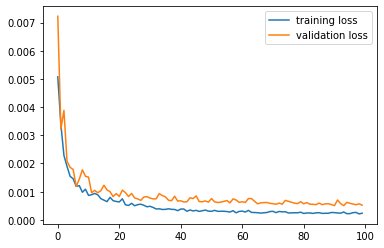

In [26]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

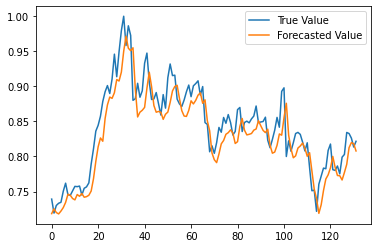

In [27]:
# This is a one step forecast (based on how we constructed our model)
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

In [ ]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
# Very much different from a univariate -- You will need predictions (or known) values for your independent values.
# Nonetheles, you will follow the same steps as shown for the univariate multi-step process.

In [ ]:
len(X[threshold:])